In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import xarray
from datetime import datetime
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
from dataset.dataset import MSGDataModule, MSGDataModulePoint
from models.ConvResNet_Jiang import ConvResNet
from models.LightningModule import LitEstimator, LitEstimatorPoint
from dataset.normalization import MinMax
from inference.estimate import MSGSingleImageDataset
from datetime import datetime

In [3]:
ckpt_fn = './SIS_point_estimation/qj5zomfa/checkpoints/epoch=4-step=14520.ckpt'

dm = MSGDataModulePoint(
        batch_size=512,
        # num_workers=12,
        patch_size=(15,15),
        input_overlap=None,
        x_vars=["channel_1", "channel_2", "channel_3", "channel_4", "channel_5", "channel_6", "channel_7", "channel_8", "channel_9", "channel_10", "channel_11"],
        y_vars=['SIS'],
        x_features='all',
        transform=MinMax(),
        target_transform=MinMax(),
    )


In [4]:

# estimator = LitEstimator()
trainer = Trainer(
    profiler='simple',
    # num_sanity_val_steps=2,
    accelerator='gpu',
    devices=-1,
    precision=32,
)

model = ConvResNet(num_attr=6, input_channels=11)

estimator = LitEstimatorPoint.load_from_checkpoint(ckpt_fn, learning_rate=.01, model=model, dm=dm)#, model=ConvResNet(5,1), dm=dm)


/scratch/snx3000/kschuurm/pytorch/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/pytorch/lib/python3.9/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/snx3000/kschuurm/pytorch/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [5]:
dm.setup('test')
input_image = dm.test_dataset.ds.sel(time=[datetime(2014,6,1,13)], method='nearest')

In [6]:

input_dims = {'lat':15,'lon':15}
patch_overlap = {'lat': input_dims['lat'] -1, 'lon':input_dims['lon']-1}

dataset = MSGSingleImageDataset(
    input_image.load(), input_dims=input_dims, x_vars=dm.x_vars,
    transform=dm.transform,
    target_transform=dm.target_transform,
    x_features=dm.x_features,
)
dataloader= DataLoader(dataset, batch_size=400, num_workers=12)

# predictions, x_features 
predictions = trainer.predict(estimator, dataloader)


/scratch/snx3000/kschuurm/pytorch/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/pytorch/lib/python3.9/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  13511          	|  888.91         	

In [7]:

y_hat = torch.vstack([x[0] for x in predictions]).squeeze()
lat = torch.hstack([x[1][:,1] for x in predictions])
lon = torch.hstack([x[1][:,2] for x in predictions])

def image_1d_to_2d(arr, input_image, input_dims):
    return arr.reshape(len(input_image.lat)-input_dims['lat']+1, len(input_image.lon) - input_dims['lon'] +1)



In [8]:
y_hat = dm.target_transform.inverse(image_1d_to_2d(y_hat, input_image, input_dims), ['SIS'])
lat = dm.transform.inverse( image_1d_to_2d(lat, input_image, input_dims), ['lat'])
lon = dm.transform.inverse( image_1d_to_2d(lon, input_image, input_dims), ['lon'])

In [9]:
lat


tensor([[35.4025, 35.4025, 35.4025,  ..., 35.4025, 35.4025, 35.4025],
        [35.4562, 35.4562, 35.4562,  ..., 35.4562, 35.4562, 35.4562],
        [35.5098, 35.5098, 35.5098,  ..., 35.5098, 35.5098, 35.5098],
        ...,
        [61.4848, 61.4848, 61.4848,  ..., 61.4848, 61.4848, 61.4848],
        [61.5385, 61.5385, 61.5385,  ..., 61.5385, 61.5385, 61.5385],
        [61.5921, 61.5921, 61.5921,  ..., 61.5921, 61.5921, 61.5921]],
       dtype=torch.float64)

In [10]:
output_image = xarray.DataArray(
    data=y_hat, 
    # dims=('x','y'),
    coords={'lat':lat[:,0], 'lon':lon[0,:]})

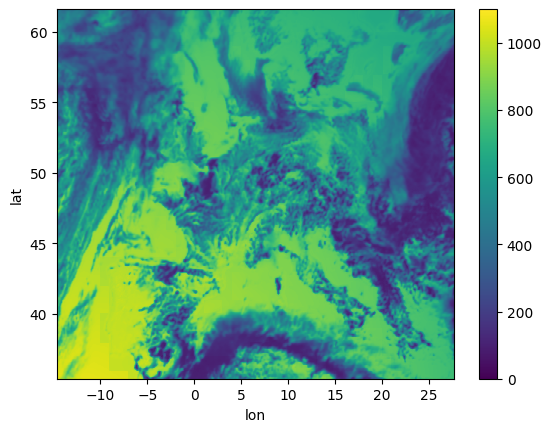

In [11]:
output_image.plot.imshow(vmin=0, vmax=1100)

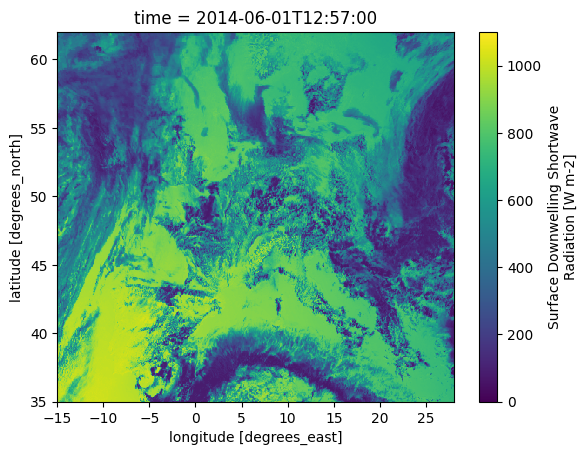

In [12]:
input_image.SIS.isel(time=0).plot.imshow(vmin=0, vmax=1100)